In [2836]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras.layers import Layer
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


import datetime
import time
import requests
import pandas as pd
import io
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from empyrical import (
    sharpe_ratio,
    calmar_ratio,
    sortino_ratio,
    max_drawdown,
    downside_risk,
    annual_return,
    annual_volatility,
    cum_returns)

# Data preprocessing

In [2837]:
csv_path = '/Users/hecate/Downloads/EU-TRAVEL.csv'
df = pd.read_csv(csv_path)

In [2838]:
df.head(10)

,DATETIME,CARRY,CARRY_CONTRACT,PRICE,PRICE_CONTRACT,FORWARD,FORWARD_CONTRACT
0,2014-03-21 09:00:00,NaN,20140900,193.5,20140600,NaN,20140900
1,2014-03-21 10:00:00,NaN,20140900,193.6,20140600,NaN,20140900
2,2014-03-21 12:00:00,NaN,20140900,194.1,20140600,NaN,20140900
3,2014-03-21 14:00:00,NaN,20140900,193.9,20140600,NaN,20140900
4,2014-03-21 15:00:00,NaN,20140900,193.1,20140600,NaN,20140900
5,2014-03-21 16:00:00,NaN,20140900,193.7,20140600,NaN,20140900
6,2014-03-21 17:00:00,NaN,20140900,194.0,20140600,NaN,20140900
7,2014-03-24 09:00:00,NaN,20140900,192.3,20140600,NaN,20140900
8,2014-03-24 10:00:00,NaN,20140900,191.9,20140600,NaN,20140900
9,2014-03-24 16:00:00,NaN,20140900,191.3,20140600,NaN,20140900


In [2839]:
df.dtypes


DATETIME             object
CARRY               float64
CARRY_CONTRACT        int64
PRICE               float64
PRICE_CONTRACT        int64
FORWARD             float64
FORWARD_CONTRACT      int64
dtype: object

In [2840]:
# use median to fill na
for col in df.columns[1:]:
    df[col] = df[col].fillna(df[col].rolling(200, min_periods=1).median()) 

df['PRICE'] = df['PRICE'].interpolate()
df['CARRY']= df['CARRY'].interpolate()
df['FORWARD'] = df['FORWARD'].interpolate()

In [2841]:
len(df)

12842

In [2842]:
# calculate classical indicators
import pandas_ta as ta


df['RSI']=ta.rsi(df.PRICE, length=15)
df['MA15']=ta.sma(df.PRICE, length=15)
df['MA20']=ta.sma(df.PRICE, length=20)
df['ROC']=ta.roc(df.PRICE, length=15)
df['Momentum'] = ta.mom(df.PRICE, length=15)
df['EMA12'] = df['PRICE'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['PRICE'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']


In [2843]:
N = 12
df['diff'] = df['PRICE'].diff().fillna(0)
df['positive_days'] = (df['diff'] > 0).rolling(window=N).sum()
# Calculate the Psychological Line (PSY)
df['PSY'] = (df['positive_days'] / N) * 100
df.drop(['positive_days'], axis=1, inplace=True)

df

,DATETIME,CARRY,CARRY_CONTRACT,PRICE,PRICE_CONTRACT,FORWARD,FORWARD_CONTRACT,RSI,MA15,MA20,ROC,Momentum,EMA12,EMA26,MACD,diff,PSY
0,2014-03-21 09:00:00,NaN,20140900,193.5,20140600,NaN,20140900,NaN,NaN,NaN,NaN,NaN,193.500000,193.500000,0.000000,0.0,NaN
1,2014-03-21 10:00:00,NaN,20140900,193.6,20140600,NaN,20140900,NaN,NaN,NaN,NaN,NaN,193.515385,193.507407,0.007977,0.1,NaN
2,2014-03-21 12:00:00,NaN,20140900,194.1,20140600,NaN,20140900,NaN,NaN,NaN,NaN,NaN,193.605325,193.551303,0.054022,0.5,NaN
3,2014-03-21 14:00:00,NaN,20140900,193.9,20140600,NaN,20140900,NaN,NaN,NaN,NaN,NaN,193.650660,193.577133,0.073527,-0.2,NaN
4,2014-03-21 15:00:00,NaN,20140900,193.1,20140600,NaN,20140900,NaN,NaN,NaN,NaN,NaN,193.565943,193.541789,0.024154,-0.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12837,2022-12-29 16:00:00,208.4,20230600,201.9,20230300,208.4,20230600,53.192322,200.313333,200.520,0.198511,0.4,200.250071,200.894873,-0.644802,1.8,66.666667
12838,2022-12-29 23:00:00,200.0,20230600,200.1,20230300,200.0,20230600,46.731010,200.333333,200.445,0.150150,0.3,200.226983,200.835993,-0.609011,-1.8,66.666667
12839,2022-12-30 08:00:00,207.9,20230600,198.9,20230300,208.4,20230600,43.000113,200.226667,200.335,-0.798005,-1.6,200.022832,200.692586,-0.669755,-1.2,58.333333
12840,2022-12-30 12:00:00,207.9,20230600,199.0,20230300,208.4,20230600,43.403553,200.026667,200.240,-1.485149,-3.0,199.865473,200.567210,-0.701737,0.1,66.666667


In [2844]:
# Calculate RSV (Raw Stochastic Value)
n = 9  
df['lowest_low'] = df['PRICE'].rolling(window=n).min()
df['highest_high'] = df['PRICE'].rolling(window=n).max()
df['RSV'] = ((df['PRICE'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low'])) * 100

# Calculate K, D, and J values
df['K'] = df['RSV'].ewm(span=3).mean()
df['D'] = df['K'].ewm(span=3).mean()
df['J'] = 3 * df['K'] - 2 * df['D']

# Fill initial values for K and D
df['K'].iloc[:n] = 50
df['D'].iloc[:n] = 50

df.drop(['lowest_low', 'highest_high', 'RSV'], axis=1, inplace=True)


/var/folders/vj/hl44tyxn2t1ccmc23733qvlh0000gn/T/ipykernel_14393/2892907625.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['K'].iloc[:n] = 50
/var/folders/vj/hl44tyxn2t1ccmc23733qvlh0000gn/T/ipykernel_14393/2892907625.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['D'].iloc[:n] = 50


In [2845]:
# Calculate RSV (Raw Stochastic Value)
n = 9  
df['lowest_low'] = df['PRICE'].rolling(window=n).min()
df['highest_high'] = df['PRICE'].rolling(window=n).max()

# Calculate K, D, and J values
df['K'] = df['RSV']= ((df['PRICE'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low'])) * 100
df['K']=df['K'].fillna(method='ffill')
df['D'] = df['K'].ewm(span=3).mean()
df['J'] = 3 * df['K'] - 2 * df['D']

# Fill initial values for K and D
#df['K'].iloc[:n] = 50
#df['D'].iloc[:n] = 50

df.drop(['lowest_low', 'highest_high', 'RSV'], axis=1, inplace=True)

In [2846]:
df = df[26:].reset_index(drop=True)
# calculate label based on signal of diff
label_list = (df['diff'] > 0).astype(int)
df['label'] = label_list

df

,DATETIME,CARRY,CARRY_CONTRACT,PRICE,PRICE_CONTRACT,FORWARD,FORWARD_CONTRACT,RSI,MA15,MA20,...,Momentum,EMA12,EMA26,MACD,diff,PSY,K,D,J,label
0,2014-03-27 14:00:00,NaN,20140900,195.5,20140600,NaN,20140900,57.412486,195.200000,194.385,...,2.9,195.378501,194.681180,0.697322,-0.4,33.333333,30.769231,52.580282,-12.852873,0
1,2014-03-27 15:00:00,NaN,20140900,195.6,20140600,NaN,20140900,58.093110,195.293333,194.550,...,1.4,195.412578,194.749240,0.663338,0.1,33.333333,38.461538,45.520904,24.342808,1
2,2014-03-27 16:00:00,NaN,20140900,195.4,20140600,NaN,20140900,56.169492,195.413333,194.725,...,1.8,195.410643,194.797445,0.613198,-0.2,33.333333,23.076923,34.298908,0.632953,0
3,2014-03-27 17:00:00,NaN,20140900,195.6,20140600,NaN,20140900,57.671227,195.540000,194.940,...,1.9,195.439775,194.856893,0.582881,0.2,33.333333,38.461538,36.380224,42.624168,1
4,2014-03-28 12:00:00,NaN,20140900,195.7,20140600,NaN,20140900,58.434160,195.633333,195.145,...,1.4,195.479809,194.919346,0.560464,0.1,41.666667,30.000000,33.190111,23.619777,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,2022-12-29 16:00:00,208.4,20230600,201.9,20230300,208.4,20230600,53.192322,200.313333,200.520,...,0.4,200.250071,200.894873,-0.644802,1.8,66.666667,100.000000,67.396150,165.207700,1
12812,2022-12-29 23:00:00,200.0,20230600,200.1,20230300,200.0,20230600,46.731010,200.333333,200.445,...,0.3,200.226983,200.835993,-0.609011,-1.8,66.666667,51.351351,59.373751,35.306553,0
12813,2022-12-30 08:00:00,207.9,20230600,198.9,20230300,208.4,20230600,43.000113,200.226667,200.335,...,-1.6,200.022832,200.692586,-0.669755,-1.2,58.333333,18.918919,39.146335,-21.535913,0
12814,2022-12-30 12:00:00,207.9,20230600,199.0,20230300,208.4,20230600,43.403553,200.026667,200.240,...,-3.0,199.865473,200.567210,-0.701737,0.1,66.666667,21.621622,30.383978,4.096908,1


# Data analysis and visualization

In [2847]:
df.describe()

,CARRY,CARRY_CONTRACT,PRICE,PRICE_CONTRACT,FORWARD,FORWARD_CONTRACT,RSI,MA15,MA20,ROC,Momentum,EMA12,EMA26,MACD,diff,PSY,K,D,J,label
count,12484.000000,1.281600e+04,12816.000000,1.281600e+04,12484.000000,1.281600e+04,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000,12816.000000
mean,227.219725,2.019181e+07,227.587352,2.018923e+07,227.540816,2.019181e+07,51.020373,227.585339,227.584084,0.037928,0.005563,227.585612,227.581812,0.003801,0.000078,45.144091,52.091840,52.096459,52.082602,0.451545
std,28.502787,2.641797e+04,29.784284,2.641291e+04,28.625479,2.641797e+04,13.083714,29.701188,29.674334,2.628935,5.488539,29.683856,29.567450,1.620266,1.540207,16.030303,39.639030,34.152638,59.960825,0.497666
min,134.000000,2.014090e+07,116.000000,2.014060e+07,134.000000,2.014090e+07,11.541047,126.953333,127.140000,-28.555368,-50.800000,128.288951,134.746152,-15.366938,-36.000000,0.000000,0.000000,0.002081,-99.983344,0.000000
25%,209.150000,2.017060e+07,203.500000,2.017030e+07,209.900000,2.017060e+07,41.887780,203.318333,203.240000,-1.209956,-2.800000,203.386110,203.085468,-0.816495,-0.500000,33.333333,8.872549,18.218577,-1.167015,0.000000
50%,230.259888,2.020030e+07,234.000000,2.019120e+07,230.250000,2.020030e+07,51.644280,234.256667,234.200000,0.118718,0.300000,234.161914,233.849619,0.174400,0.000000,41.666667,54.545455,53.661835,54.861806,0.000000
75%,251.760426,2.021120e+07,253.300000,2.021090e+07,251.760426,2.021120e+07,60.452715,253.360000,253.436250,1.389770,3.100000,253.546655,253.681172,0.976221,0.500000,58.333333,96.059082,86.024727,102.631783,1.000000
max,265.100000,2.023060e+07,286.700000,2.023030e+07,272.200000,2.023060e+07,90.795111,283.246667,283.155000,23.671498,36.000000,283.268914,281.417798,6.107099,38.900000,100.000000,100.000000,99.999921,199.996916,1.000000


array([[<Axes: title={'center': 'PRICE'}>,
        <Axes: title={'center': 'CARRY_CONTRACT'}>]], dtype=object)

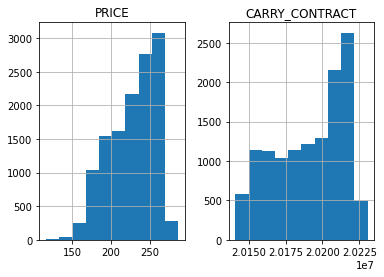

In [2848]:
df[[ 'PRICE', 'CARRY_CONTRACT']].hist()

<Axes: >

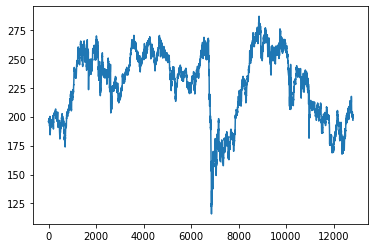

In [2849]:
df['PRICE'].plot()

In [2850]:
df['label'].value_counts()

0    7029
1    5787
Name: label, dtype: int64

In [2851]:
# correlation pearson
df_corr = df.corr(method='pearson')
df_corr

/var/folders/vj/hl44tyxn2t1ccmc23733qvlh0000gn/T/ipykernel_14393/2816075921.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method='pearson')


,CARRY,CARRY_CONTRACT,PRICE,PRICE_CONTRACT,FORWARD,FORWARD_CONTRACT,RSI,MA15,MA20,ROC,Momentum,EMA12,EMA26,MACD,diff,PSY,K,D,J,label
CARRY,1.000000,-0.223446,0.925724,-0.203009,0.999028,-0.223446,-0.035430,0.929152,0.930061,-0.013989,-0.004880,0.929462,0.932834,0.009033,-0.004092,0.067182,-0.012340,-0.013698,-0.008868,0.020186
CARRY_CONTRACT,-0.223446,1.000000,-0.164850,0.989346,-0.212145,1.000000,-0.044333,-0.163536,-0.163040,-0.017295,-0.020698,-0.164011,-0.162864,-0.032712,-0.004963,-0.191606,-0.035082,-0.040753,-0.023152,-0.061963
PRICE,0.925724,-0.164850,1.000000,-0.155352,0.920939,-0.164850,0.095861,0.994875,0.992954,0.077947,0.091112,0.997097,0.993086,0.144845,0.025803,0.128755,0.041135,0.047656,0.027292,0.041253
PRICE_CONTRACT,-0.203009,0.989346,-0.155352,1.000000,-0.190840,0.989346,-0.047866,-0.153612,-0.152958,-0.021799,-0.025386,-0.154161,-0.152548,-0.040510,-0.006032,-0.204687,-0.033876,-0.039307,-0.022406,-0.066228
FORWARD,0.999028,-0.212145,0.920939,-0.190840,1.000000,-0.212145,-0.037707,0.924420,0.925357,-0.014830,-0.005780,0.924714,0.928153,0.007474,-0.004235,0.059084,-0.013580,-0.015192,-0.009627,0.017633
FORWARD_CONTRACT,-0.223446,1.000000,-0.164850,0.989346,-0.212145,1.000000,-0.044333,-0.163536,-0.163040,-0.017295,-0.020698,-0.164011,-0.162864,-0.032712,-0.004963,-0.191606,-0.035082,-0.040753,-0.023152,-0.061963
RSI,-0.035430,-0.044333,0.095861,-0.047866,-0.037707,-0.044333,1.000000,0.015102,-0.004499,0.765392,0.802706,0.034836,-0.008365,0.790857,0.300039,0.546797,0.691064,0.754776,0.510736,0.243738
MA15,0.929152,-0.163536,0.994875,-0.153612,0.924420,-0.163536,0.015102,1.000000,0.999526,-0.006451,0.005129,0.999545,0.998941,0.082834,-0.018814,0.077002,-0.032750,-0.030657,-0.030029,0.013736
MA20,0.930061,-0.163040,0.992954,-0.152958,0.925357,-0.163040,-0.004499,0.999526,1.000000,-0.030855,-0.019594,0.998710,0.999505,0.057236,-0.019971,0.066611,-0.038623,-0.039282,-0.031851,0.012824
ROC,-0.013989,-0.017295,0.077947,-0.021799,-0.014830,-0.017295,0.765392,-0.006451,-0.030855,1.000000,0.982702,0.016651,-0.026140,0.782063,0.255166,0.483912,0.497606,0.577874,0.328581,0.162258


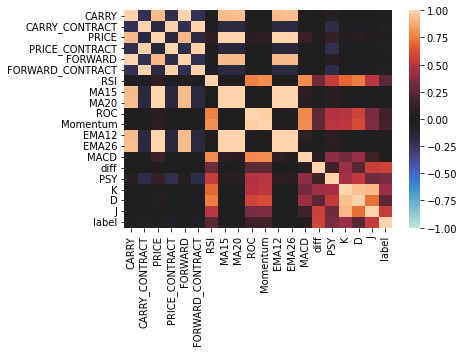

In [2852]:
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0)
plt.savefig('./seaborn_heatmap_corr_example.png')

In [2853]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [2854]:
def create_time_steps(length):
  return list(range(-length, 0))

In [2855]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [2856]:
def plot_predict_one(y_label,y_predict_lstm, title):

  epochs = range(len(y_label))

  plt.figure()

  plt.plot(epochs, y_label, 'b', label='y_label')
  # for y_predict in y_predict_list:
  plt.plot(epochs, y_predict_lstm, 'r', label=title)
  plt.title(title)
  plt.legend()

  plt.show()

In [2857]:
features_considered = [ 'PRICE', 'PRICE_CONTRACT',
       'EMA12', 'diff', 'MACD', 'RSI', 'PSY', 'ROC', 'J','K','D'] 

In [2858]:
features = df[features_considered]
features.index = df['DATETIME']
features

,PRICE,PRICE_CONTRACT,EMA12,diff,MACD,RSI,PSY,ROC,J,K,D
DATETIME,,,,,,,,,,,
2014-03-27 14:00:00,195.5,20140600,195.378501,-0.4,0.697322,57.412486,33.333333,1.505711,-12.852873,30.769231,52.580282
2014-03-27 15:00:00,195.6,20140600,195.412578,0.1,0.663338,58.093110,33.333333,0.720906,24.342808,38.461538,45.520904
2014-03-27 16:00:00,195.4,20140600,195.410643,-0.2,0.613198,56.169492,33.333333,0.929752,0.632953,23.076923,34.298908
2014-03-27 17:00:00,195.6,20140600,195.439775,0.2,0.582881,57.671227,33.333333,0.980898,42.624168,38.461538,36.380224
2014-03-28 12:00:00,195.7,20140600,195.479809,0.1,0.560464,58.434160,41.666667,0.720535,23.619777,30.000000,33.190111
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 16:00:00,201.9,20230300,200.250071,1.8,-0.644802,53.192322,66.666667,0.198511,165.207700,100.000000,67.396150
2022-12-29 23:00:00,200.1,20230300,200.226983,-1.8,-0.609011,46.731010,66.666667,0.150150,35.306553,51.351351,59.373751
2022-12-30 08:00:00,198.9,20230300,200.022832,-1.2,-0.669755,43.000113,58.333333,-0.798005,-21.535913,18.918919,39.146335


## Data visualization

array([<Axes: xlabel='DATETIME'>, <Axes: xlabel='DATETIME'>,
       <Axes: xlabel='DATETIME'>, <Axes: xlabel='DATETIME'>,
       <Axes: xlabel='DATETIME'>, <Axes: xlabel='DATETIME'>,
       <Axes: xlabel='DATETIME'>, <Axes: xlabel='DATETIME'>,
       <Axes: xlabel='DATETIME'>, <Axes: xlabel='DATETIME'>,
       <Axes: xlabel='DATETIME'>], dtype=object)

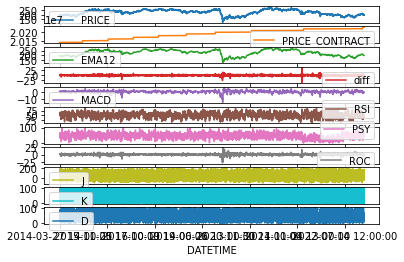

In [2859]:
features.plot(subplots=True)

## Data normalization

In [2860]:
dataset = features.values

TRAIN_SPLIT = int(len(dataset) * 0.8)

train_data = dataset[:TRAIN_SPLIT]
val_data = dataset[TRAIN_SPLIT:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

dataset = np.concatenate((train_data, val_data), axis=0)

## Split train and test

In [2861]:
BATCH_SIZE = 256

In [2862]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [2863]:
past_history = 15
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, label_list, 0,
                          TRAIN_SPLIT, past_history,
                          future_target, STEP,
                          single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, label_list,
                        TRAIN_SPLIT, None, past_history,
                        future_target, STEP,
                        single_step=True)

In [2864]:
y_val_single

array([0, 0, 0, ..., 0, 1, 0])

In [2865]:
y_train_single.shape

(10237,)

In [2866]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (15, 11)


In [2867]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(TRAIN_SPLIT).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [2868]:
# Input shape
train_input_shape = x_train_single.shape[-2:]

seq_len = x_train_single.shape[1]
x_train_single.shape, train_input_shape, seq_len 

((10237, 15, 11), (15, 11), 15)

# Random Forest Model

In [2869]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2870]:
fen_shape = x_train_single.shape
x_train_single.reshape(fen_shape[0],-1)

array([[4.65729350e-01, 0.00000000e+00, 4.32891767e-01, ...,
        3.62487058e-01, 3.80952381e-01, 5.27675921e-01],
       [4.66315173e-01, 0.00000000e+00, 4.33111645e-01, ...,
        5.38709931e-01, 5.71428571e-01, 5.49536201e-01],
       [4.65143527e-01, 0.00000000e+00, 4.33099159e-01, ...,
        4.36000747e-01, 4.28571429e-01, 4.89027372e-01],
       ...,
       [6.03983597e-01, 1.00000000e+00, 5.93096173e-01, ...,
        3.32554011e-01, 0.00000000e+00, 9.89216033e-04],
       [6.03983597e-01, 1.00000000e+00, 5.91997297e-01, ...,
        3.32922787e-01, 0.00000000e+00, 4.36970157e-04],
       [6.03983597e-01, 1.00000000e+00, 5.91067479e-01, ...,
        3.33107175e-01, 0.00000000e+00, 1.60847220e-04]])

In [2871]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)

In [2872]:
# train the model

rf.fit(x_train_single.reshape(fen_shape[0],-1), y_train_single)

RandomForestClassifier(n_estimators=10, random_state=42)

In [2873]:
# forecast
fen_shape_val = x_val_single.shape
rf.score(x_val_single.reshape(fen_shape_val[0],-1),y_val_single)

0.5682888540031397

### Results

In [2874]:
predict_label1 = rf.predict(x_val_single.reshape(fen_shape_val[0],-1))
predict_label1[:5]

array([0, 0, 1, 1, 1])

In [2875]:
predict_score_list1 = rf.predict_proba(x_val_single.reshape(fen_shape_val[0],-1))[:,1]
predict_score_list1

array([0.3, 0.4, 0.7, ..., 0.8, 0.5, 0.5])

### roc

In [2876]:
y_val_single

array([0, 0, 0, ..., 0, 1, 0])

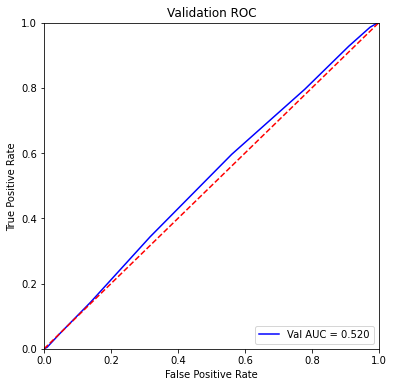

In [2877]:
fpr1, tpr1, threshold = metrics.roc_curve(y_val_single, predict_score_list1)
roc_auc1 = metrics.auc(fpr1, tpr1)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr1, tpr1, 'b', label = 'Val AUC = %0.3f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### auc

In [2878]:
roc_auc_score(y_val_single, predict_score_list1)

0.5195540317009465

### classification report

In [2879]:
cr1=classification_report(y_val_single, predict_label1,digits=4)
print(cr1)

              precision    recall  f1-score   support

           0     0.6705    0.6833    0.6769      1686
           1     0.3566    0.3434    0.3499       862

    accuracy                         0.5683      2548
   macro avg     0.5136    0.5133    0.5134      2548
weighted avg     0.5643    0.5683    0.5662      2548



### confusion matrix

In [2880]:
cnf_matrix = confusion_matrix(y_val_single, predict_label1)
cnf_matrix

array([[1152,  534],
       [ 566,  296]])

<Axes: >

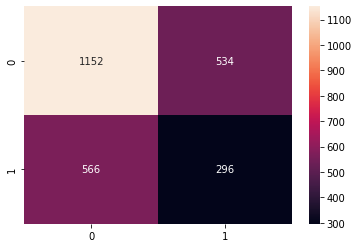

In [2881]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

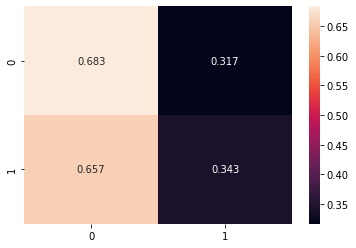

In [2882]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2883]:
cum_return=[]


df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label1']=predict_label1
#df1['new_pred_label']=new_pred_label

df1['pred_return1'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label1'] == 0 else row['return'] if row['pred_label1'] == 1 else 0, axis=1)

df1['Cum_return1'] = (1 + df1['pred_return1']).cumprod()-1
df1.drop('pred_return1', axis=1, inplace=True)

df1['Cum_return1'].iloc[-1]

0.3567759940773281

# Decision Tree

In [2884]:
from sklearn import tree

In [2885]:
clf = tree.DecisionTreeClassifier()

In [2886]:
clf.fit(x_train_single.reshape(fen_shape[0],-1), y_train_single)

DecisionTreeClassifier()

In [2887]:
y_train_single

array([0, 1, 0, ..., 0, 0, 0])

In [2888]:
# predict
fen_shape_val = x_val_single.shape
clf.score(x_val_single.reshape(fen_shape_val[0],-1),y_val_single)

0.5051020408163265

### Results

In [2889]:
predict_label2 = clf.predict(x_val_single.reshape(fen_shape_val[0],-1))
predict_label2[:5]

array([1, 1, 0, 1, 0])

In [2890]:
predict_score_list2 = clf.predict_proba(x_val_single.reshape(fen_shape_val[0],-1))[:,1]
predict_score_list2

array([1., 1., 0., ..., 1., 0., 1.])

### roc

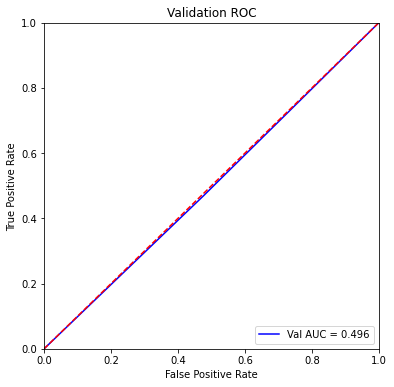

In [2891]:
fpr2, tpr2, threshold = metrics.roc_curve(y_val_single, predict_score_list2)
roc_auc2 = metrics.auc(fpr2, tpr2)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr2, tpr2, 'b', label = 'Val AUC = %0.3f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### auc

In [2892]:
roc_auc_score(y_val_single, predict_score_list2)

0.4964846298024126

### classification report

In [2893]:
cr2=classification_report(y_val_single, predict_label2,digits=4)
print(cr2)

              precision    recall  f1-score   support

           0     0.6587    0.5231    0.5831      1686
           1     0.3350    0.4698    0.3911       862

    accuracy                         0.5051      2548
   macro avg     0.4968    0.4965    0.4871      2548
weighted avg     0.5492    0.5051    0.5182      2548



### confusion matrix

In [2894]:
cnf_matrix2 = confusion_matrix(y_val_single, predict_label2)
cnf_matrix2

array([[882, 804],
       [457, 405]])

<Axes: >

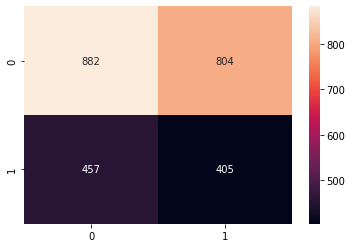

In [2895]:
sns.heatmap(cnf_matrix2, annot=True, fmt='g')

<Axes: >

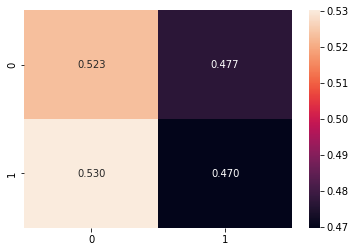

In [2896]:
cm_normalized = cnf_matrix2.astype('float') / cnf_matrix2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2897]:
def get_pred_label(item,threshold, gap):
  low_line = threshold-gap
  high_line = threshold+gap
  if item<low_line:
    return 0
  elif item >= low_line and item <= high_line:
    return -1
  elif item > high_line:
    return 1 

In [2835]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label2']=predict_label2
#df1['new_pred_label']=new_pred_label

df1['pred_return2'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label2'] == 0 else row['return'] if row['pred_label2'] == 1 else 0, axis=1)

df1['Cum_return2'] = (1 + df1['pred_return2']).cumprod()-1
df1.drop('pred_return2', axis=1, inplace=True)

df1['Cum_return2'].iloc[-1]

-0.2686710953689456

# transformer

### add transformer encoder

In [2339]:
embed_dim = 11  # Embedding size for each token
num_heads = 1  # Number of attention heads
ff_dim = 10  # Hidden layer size in feed forward network inside transformer


In [2340]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

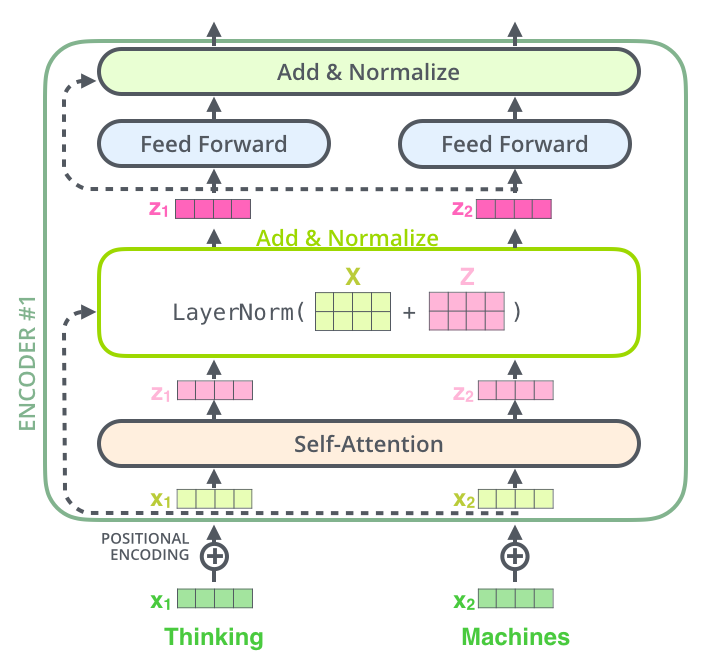

In [2341]:
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

### create transformer model

In [2342]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

In [2343]:
sample_learning_rate = CustomeLearningSchedule(d_model=300)
D_MODEL=300

In [2344]:
input_tensor = tf.keras.Input(shape=train_input_shape)
mid_tensor = transformer_block(input_tensor)
# mid_tensor = tf.keras.layers.GlobalMaxPooling1D()(mid_tensor)
mid_tensor = tf.keras.layers.Flatten()(mid_tensor)
mid_tensor = tf.keras.layers.Dense(50)(mid_tensor)
final_tensor = tf.keras.layers.Dense(2)(mid_tensor)

# Instantiate an end-to-end model predicting both priority and department
transformer_model = tf.keras.Model(inputs=input_tensor,outputs=final_tensor,)

transformer_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=CustomeLearningSchedule(D_MODEL),
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# transformer_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mae','mse',tf.keras.metrics.RootMeanSquaredError()])

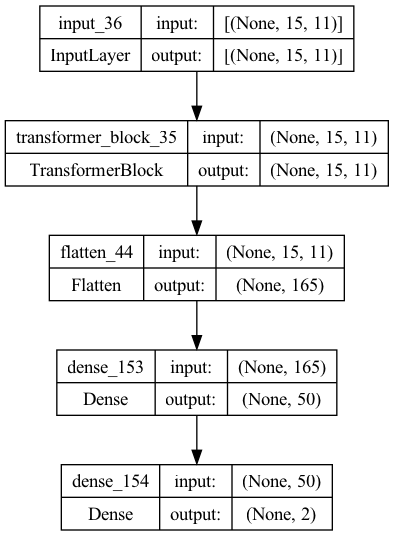

In [2345]:
tensorflow.keras.utils.plot_model(transformer_model, show_shapes=True)

In [2346]:
transformer_model_history = transformer_model.fit(train_data_single,  epochs=30,validation_data=val_data_single)

Epoch 1/30
40/40 [==============================] - 1s 7ms/step - loss: 0.9392 - accuracy: 0.4929 - val_loss: 0.7812 - val_accuracy: 0.6189
Epoch 2/30
40/40 [==============================] - 0s 4ms/step - loss: 0.8910 - accuracy: 0.4929 - val_loss: 0.7645 - val_accuracy: 0.6382
Epoch 3/30
40/40 [==============================] - 0s 5ms/step - loss: 0.8242 - accuracy: 0.4949 - val_loss: 0.7198 - val_accuracy: 0.6445
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 0.7894 - accuracy: 0.4939 - val_loss: 0.6753 - val_accuracy: 0.6359
Epoch 5/30
40/40 [==============================] - 0s 5ms/step - loss: 0.7664 - accuracy: 0.4925 - val_loss: 0.6647 - val_accuracy: 0.6098
Epoch 6/30
40/40 [==============================] - 0s 5ms/step - loss: 0.7507 - accuracy: 0.4976 - val_loss: 0.6748 - val_accuracy: 0.5893
Epoch 7/30
40/40 [==============================] - 0s 5ms/step - loss: 0.7417 - accuracy: 0.5075 - val_loss: 0.6690 - val_accuracy: 0.5987
Epoch 8/30
40/40 [==

In [2347]:
for x, y in val_data_single.take(1):
  print(transformer_model.predict(x).shape)

8/8 [==============================] - 0s 866us/step
(256, 2)


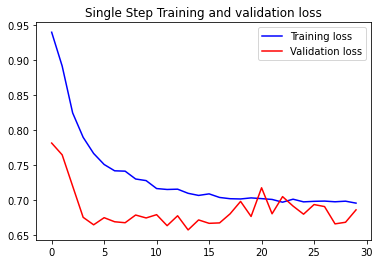

In [2348]:
plot_train_history(transformer_model_history,
                   'Single Step Training and validation loss')

### Results

In [2349]:
predict_score3 = transformer_model.predict(x_val_single)
predict_pro3 = layers.Softmax()(predict_score3)[:,1]
predict_label3 = np.argmax(predict_score3,axis=1)
predict_score3[:5],predict_pro3[:5],predict_label3[:5],y_val_single[:5]

80/80 [==============================] - 0s 648us/step


(array([[1.7980112, 1.5530051],
        [1.6700983, 1.4581835],
        [1.8802726, 1.5217652],
        [1.2596147, 1.2789617],
        [1.0053967, 0.960453 ]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.43905303, 0.4472187 , 0.41132092, 0.50483656, 0.48876593],
       dtype=float32)>,
 array([0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0]))

### roc

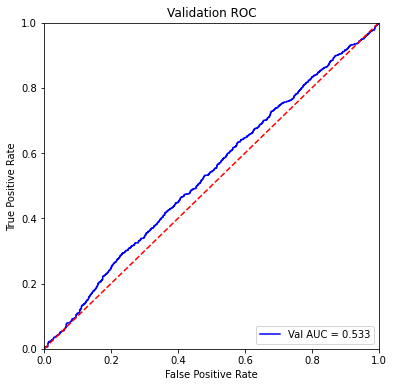

In [2350]:
fpr3, tpr3, threshold = metrics.roc_curve(y_val_single, predict_pro3)
roc_auc3 = metrics.auc(fpr3, tpr3)
#fpr31, tpr31, threshold = metrics.roc_curve(pd_select['label'], pd_select['new_pred_label'])
#roc_auc31 = metrics.auc(fpr31, tpr31)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr3, tpr3, 'b', label = 'Val AUC = %0.3f' % roc_auc3)
#plt.plot(fpr31, tpr31, 'b', label = 'Val AUC1 = %0.3f' % roc_auc31)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2351]:
p=df['label'].value_counts(1)[0]*100

threshold = np.percentile(predict_pro3, 57)
print("threshold", threshold)

threshold 0.49538736969232555


In [2352]:
predict_label3 = [1 if score>threshold else 0 for score in predict_pro3]

### auc

In [2353]:
roc_auc_score(y_val_single, predict_pro3)

0.532912998127488

### classification report

In [2354]:
cr3=classification_report(y_val_single, predict_label3,digits=4)
print(cr3)

              precision    recall  f1-score   support

           0     0.6819    0.5882    0.6316      1673
           1     0.3673    0.4657    0.4107       859

    accuracy                         0.5466      2532
   macro avg     0.5246    0.5269    0.5211      2532
weighted avg     0.5752    0.5466    0.5566      2532



### confusion matrix

In [2355]:
cnf_matrix3 = confusion_matrix(y_val_single, predict_label3)
cnf_matrix3

array([[984, 689],
       [459, 400]])

<Axes: >

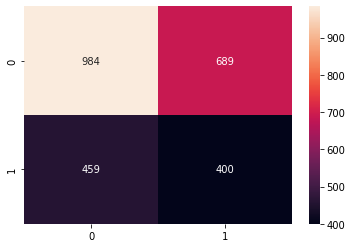

In [2356]:
sns.heatmap(cnf_matrix3, annot=True, fmt='g')

<Axes: >

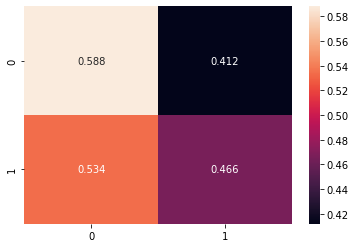

In [2357]:
cm_normalized = cnf_matrix3.astype('float') / cnf_matrix3.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2358]:
new_pred_label = [get_pred_label(item, threshold,0.03) for item in predict_pro3]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro3, 'new_pred_label':new_pred_label})
pd_select = pd_result[pd_result.new_pred_label != -1]
len(pd_select)

1078

In [2359]:
#pred_label3=new_pred_label

In [2360]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label3
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]

0.4060743447659234

# LSTM

In [2361]:
# Define the dropout rate
dropout_rate = 0.1

lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:], dropout=dropout_rate))
lstm_model.add(tf.keras.layers.Dropout(rate=dropout_rate))
lstm_model.add(tf.keras.layers.Dense(2))

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


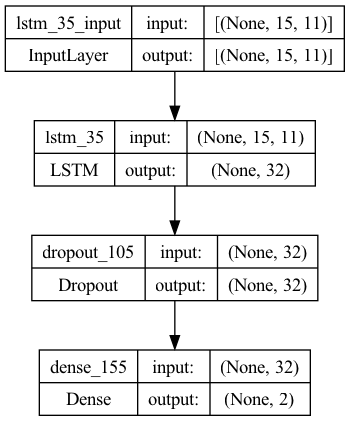

In [2362]:
tensorflow.keras.utils.plot_model(lstm_model, show_shapes=True)

In [2607]:
lstm_model_history = lstm_model.fit(train_data_single,batch_size =64, epochs=20,validation_data=val_data_single)

Epoch 1/20
40/40 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5241 - val_loss: 0.6837 - val_accuracy: 0.6070
Epoch 2/20
40/40 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5249 - val_loss: 0.6708 - val_accuracy: 0.6426
Epoch 3/20
40/40 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5226 - val_loss: 0.6820 - val_accuracy: 0.6189
Epoch 4/20
40/40 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 0.5221 - val_loss: 0.6824 - val_accuracy: 0.6019
Epoch 5/20
40/40 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5181 - val_loss: 0.6829 - val_accuracy: 0.6031
Epoch 6/20
40/40 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5248 - val_loss: 0.6840 - val_accuracy: 0.5995
Epoch 7/20
40/40 [==============================] - 0s 8ms/step - loss: 0.6909 - accuracy: 0.5275 - val_loss: 0.6749 - val_accuracy: 0.6370
Epoch 8/20
40/40 [==

In [2608]:
for x, y in val_data_single.take(1):
  print(lstm_model.predict(x).shape)

8/8 [==============================] - 0s 4ms/step
(256, 2)


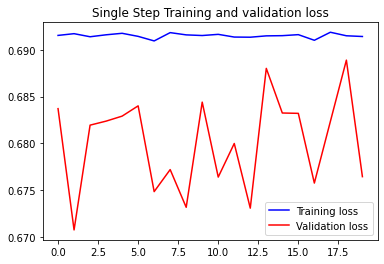

In [2609]:
plot_train_history(lstm_model_history,
                   'Single Step Training and validation loss')

### Results

In [2610]:
predict_score4 = lstm_model.predict(x_val_single)
predict_pro4 = layers.Softmax()(predict_score4)[:,1]
predict_label4 = np.argmax(predict_score4,axis=1)
predict_score4[:5],predict_pro4[:5],predict_label4[:5],y_val_single[:5]

 1/80 [..............................] - ETA: 1s80/80 [==============================] - 0s 985us/step


(array([[-0.01944244, -0.21325047],
        [ 0.0376038 , -0.2101369 ],
        [ 0.0779615 , -0.175554  ],
        [ 0.05817718, -0.13378674],
        [ 0.01178983, -0.09173867]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.4516991 , 0.43837965, 0.4369584 , 0.45215583, 0.47414097],
       dtype=float32)>,
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]))

### roc

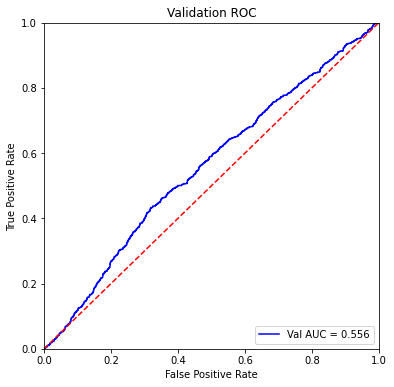

In [2611]:
fpr4, tpr4, threshold = metrics.roc_curve(y_val_single, predict_pro4)
roc_auc4 = metrics.auc(fpr4, tpr4)
fpr41, tpr41, threshold = metrics.roc_curve(pd_select['label'], pd_select['new_pred_label'])
roc_auc41 = metrics.auc(fpr41, tpr41)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr4, tpr4, 'b', label = 'Val AUC = %0.3f' % roc_auc4)
#plt.plot(fpr41, tpr41, 'b', label = 'Val AUC update = %0.3f' % roc_auc41)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2612]:
p=df['label'].value_counts(1)[0]*100

threshold = np.percentile(predict_pro4, p)
print("threshold", threshold)

threshold 0.4777792662330654


In [2613]:
predict_label4 = [1 if score>threshold else 0 for score in predict_pro4]

### auc

In [2614]:
roc_auc_score(y_val_single, predict_pro4)

0.5561155154069948

### classification report

In [2615]:
cr4=classification_report(y_val_single, predict_label4,digits=4)
print(cr4)

              precision    recall  f1-score   support

           0     0.6945    0.5762    0.6299      1673
           1     0.3802    0.5064    0.4343       859

    accuracy                         0.5525      2532
   macro avg     0.5374    0.5413    0.5321      2532
weighted avg     0.5879    0.5525    0.5635      2532



### confusion matrix

In [2616]:
cnf_matrix4 = confusion_matrix(y_val_single, predict_label4)
cnf_matrix4

array([[964, 709],
       [424, 435]])

<Axes: >

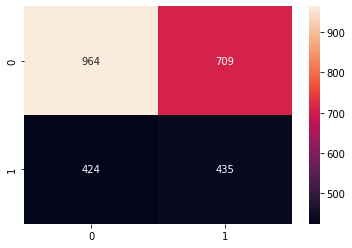

In [2617]:
sns.heatmap(cnf_matrix4, annot=True, fmt='g')

<Axes: >

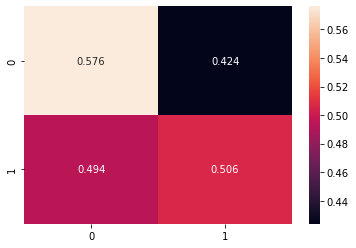

In [2618]:
cm_normalized = cnf_matrix4.astype('float') / cnf_matrix4.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2619]:
new_pred_label = [get_pred_label(item,threshold, 0.0) for item in predict_pro4]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro4, 'new_pred_label':new_pred_label})
pd_result
pd_select = pd_result[pd_result.new_pred_label != -1]
len(pd_select) 

2532

In [2620]:
predict_label4=new_pred_label

In [2621]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label4
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]

1.3558397061705292

# CNN

In [2378]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(32,3,
            input_shape=x_train_single.shape[-2:]))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(2))

cnn_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=CustomeLearningSchedule(D_MODEL),
                                     beta_1=0.9,
                                     beta_2=0.95,
                                     epsilon=1e-8),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

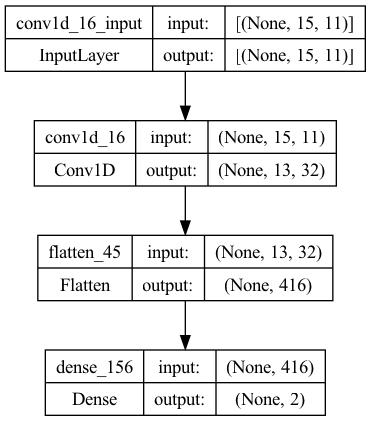

In [2379]:
tensorflow.keras.utils.plot_model(cnn_model, show_shapes=True)

In [2380]:
cnn_model_history = cnn_model.fit(train_data_single, epochs=30,validation_data=val_data_single)

Epoch 1/30
40/40 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.5080 - val_loss: 0.6970 - val_accuracy: 0.5083
Epoch 2/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.5143 - val_loss: 0.6892 - val_accuracy: 0.5312
Epoch 3/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6945 - accuracy: 0.5173 - val_loss: 0.6895 - val_accuracy: 0.5304
Epoch 4/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6942 - accuracy: 0.5189 - val_loss: 0.6901 - val_accuracy: 0.5296
Epoch 5/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5200 - val_loss: 0.6891 - val_accuracy: 0.5407
Epoch 6/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5205 - val_loss: 0.6866 - val_accuracy: 0.5561
Epoch 7/30
40/40 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5205 - val_loss: 0.6903 - val_accuracy: 0.5336
Epoch 8/30
40/40 [==

In [2381]:
for x, y in val_data_single.take(1):
  print(cnn_model.predict(x).shape)

8/8 [==============================] - 0s 623us/step
(256, 2)


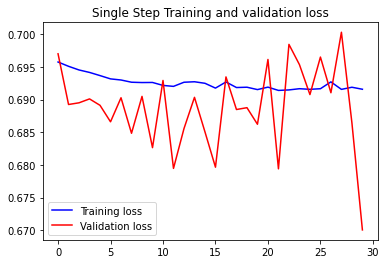

In [2382]:
plot_train_history(cnn_model_history,
                   'Single Step Training and validation loss')

### Results

In [2383]:
predict_score5 = cnn_model.predict(x_val_single)
predict_pro5 = layers.Softmax()(predict_score5)[:,1]
predict_label5 = np.argmax(predict_score5,axis=1)
predict_score5[:5],predict_pro5[:5],predict_label5[:5],y_val_single[:5]

80/80 [==============================] - 0s 951us/step


(array([[0.46362773, 0.19686851],
        [0.4500555 , 0.24149624],
        [0.6438187 , 0.2153805 ],
        [0.64834315, 0.56789017],
        [0.7718084 , 0.6320463 ]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.43370286, 0.44804835, 0.39449933, 0.47989756, 0.46511626],
       dtype=float32)>,
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]))

### roc

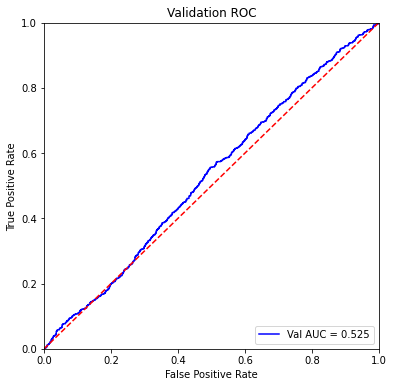

In [2384]:
fpr5, tpr5, threshold = metrics.roc_curve(y_val_single, predict_pro5)
roc_auc5 = metrics.auc(fpr5, tpr5)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr5, tpr5, 'b', label = 'Val AUC = %0.3f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2385]:
p=df['label'].value_counts(1)[0]*100

threshold = np.percentile(predict_pro5, 57)
print("threshold", threshold)

threshold 0.46524209320545196


In [2386]:
predict_label5 = [1 if score>threshold else 0 for score in predict_pro5]

### auc

In [2387]:
roc_auc_score(y_val_single, predict_pro5)

0.5250590248325282

### classification report

In [2388]:
cr5=classification_report(y_val_single, predict_label5,digits=4)
print(cr5)

              precision    recall  f1-score   support

           0     0.6722    0.5798    0.6226      1673
           1     0.3545    0.4494    0.3963       859

    accuracy                         0.5355      2532
   macro avg     0.5133    0.5146    0.5094      2532
weighted avg     0.5644    0.5355    0.5458      2532



### confusion matrix

In [2389]:
cnf_matrix5 = confusion_matrix(y_val_single, predict_label5)
cnf_matrix5

array([[970, 703],
       [473, 386]])

<Axes: >

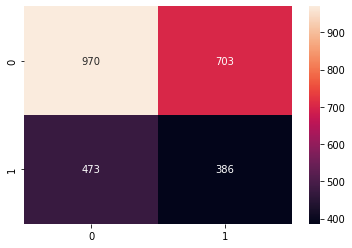

In [2390]:
sns.heatmap(cnf_matrix5, annot=True, fmt='g')

<Axes: >

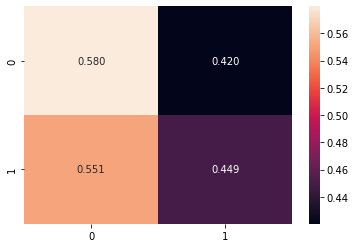

In [2391]:
cm_normalized = cnf_matrix5.astype('float') / cnf_matrix5.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2392]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label4
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]

0.011098390199018704

# lstm+cnn

In [2393]:
input_tensor = tf.keras.Input(shape=train_input_shape)
mid_tensor = tf.keras.layers.LSTM(32,return_sequences=True)(input_tensor)
mid_tensor = tf.keras.layers.Conv1D(10,3)(mid_tensor)
mid_tensor = tf.keras.layers.Flatten()(mid_tensor)
dropout_rate = 0.1
mid_tensor = tf.keras.layers.Dropout(rate=dropout_rate)(mid_tensor)
final_tensor = tf.keras.layers.Dense(2)(mid_tensor)

# Instantiate an end-to-end model predicting both priority and department
lstm_cnn_model = tf.keras.Model(inputs=input_tensor,outputs=final_tensor,)

lstm_cnn_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

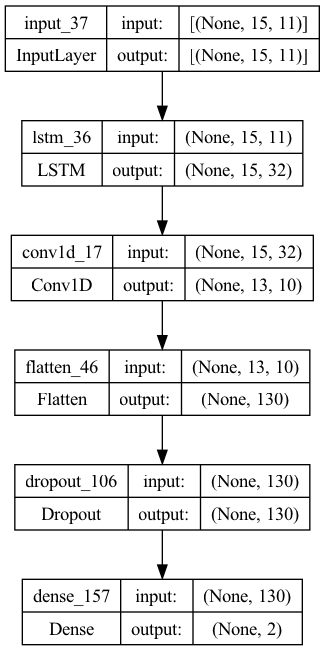

In [2394]:
tensorflow.keras.utils.plot_model(lstm_cnn_model, show_shapes=True)

In [2395]:
lstm_cnn_model_history = lstm_cnn_model.fit(train_data_single, epochs=30,validation_data=val_data_single)

Epoch 1/30
40/40 [==============================] - 1s 11ms/step - loss: 0.6997 - accuracy: 0.5046 - val_loss: 0.6848 - val_accuracy: 0.6536
Epoch 2/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5170 - val_loss: 0.6703 - val_accuracy: 0.6611
Epoch 3/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5131 - val_loss: 0.6744 - val_accuracy: 0.6607
Epoch 4/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5160 - val_loss: 0.6709 - val_accuracy: 0.6607
Epoch 5/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5171 - val_loss: 0.6748 - val_accuracy: 0.6607
Epoch 6/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.5153 - val_loss: 0.6957 - val_accuracy: 0.4625
Epoch 7/30
40/40 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5188 - val_loss: 0.6837 - val_accuracy: 0.6390
Epoch 8/30
40/40 [=

In [2396]:
for x, y in val_data_single.take(1):
  print(lstm_cnn_model.predict(x).shape)

8/8 [==============================] - 0s 1ms/step
(256, 2)


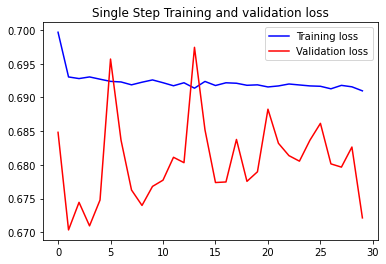

In [2397]:
plot_train_history(lstm_cnn_model_history,
                   'Single Step Training and validation loss')

### Results

In [2398]:
predict_score6 = lstm_cnn_model.predict(x_val_single)
predict_pro6 = layers.Softmax()(predict_score6)[:,1]
predict_label6= np.argmax(predict_score6,axis=1)
predict_score6[:5],predict_pro6[:5],predict_label6[:5],y_val_single[:5]

80/80 [==============================] - 0s 812us/step


(array([[ 0.22583674,  0.03566077],
        [ 0.23744962,  0.03899911],
        [ 0.2505925 , -0.00738204],
        [ 0.19744276,  0.03813252],
        [ 0.19605342,  0.05996436]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.45259878, 0.4505495 , 0.43586168, 0.46025646, 0.46603015],
       dtype=float32)>,
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]))

### roc

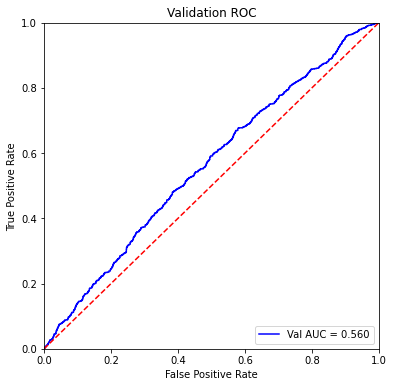

In [2399]:
fpr6, tpr6, threshold = metrics.roc_curve(y_val_single, predict_pro6)
roc_auc6 = metrics.auc(fpr6, tpr6)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr6, tpr6, 'b', label = 'Val AUC = %0.3f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2496]:
p=df['label'].value_counts(1)[0]*100

threshold = np.percentile(predict_pro6, p)
print("threshold", threshold)

threshold 0.47060256563320063


In [2497]:
predict_label6 = [1 if score>=threshold else 0 for score in predict_pro6]

### auc

In [2498]:
roc_auc_score(y_val_single, predict_pro6)

0.5598581038155127

### classification report

In [2499]:
cr6=classification_report(y_val_single, predict_label6,digits=4)
print(cr6)

              precision    recall  f1-score   support

           0     0.6967    0.5780    0.6318      1673
           1     0.3829    0.5099    0.4373       859

    accuracy                         0.5549      2532
   macro avg     0.5398    0.5439    0.5346      2532
weighted avg     0.5902    0.5549    0.5658      2532



### confusion matrix

In [2500]:
cnf_matrix6 = confusion_matrix(y_val_single, predict_label6)
cnf_matrix6

array([[967, 706],
       [421, 438]])

<Axes: >

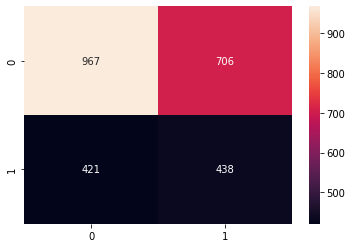

In [2501]:
sns.heatmap(cnf_matrix6, annot=True, fmt='g')

<Axes: >

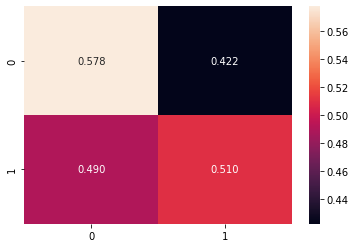

In [2502]:
cm_normalized = cnf_matrix6.astype('float') / cnf_matrix6.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2503]:
new_pred_label = [get_pred_label(item,threshold, 0.0) for item in predict_pro6]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro6, 'new_pred_label':new_pred_label})
pd_result
pd_select = pd_result[pd_result.new_pred_label != -1]
len(pd_select)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


2532

In [2504]:
predict_label6=new_pred_label

In [2505]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label6
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]


1.689408051606951

# transformer + lstm  series connected

### add transformer encoder

In [2410]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


In [2411]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [2412]:
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

### create transformer model

In [2413]:
input_tensor = tf.keras.Input(shape=train_input_shape)
mid_tensor = tf.keras.layers.LSTM(32,return_sequences=True)(input_tensor)
mid_tensor = transformer_block(mid_tensor)
# mid_tensor = tf.keras.layers.GlobalMaxPooling1D()(mid_tensor)
mid_tensor = tf.keras.layers.Flatten()(mid_tensor)
mid_tensor = tf.keras.layers.Dense(20)(mid_tensor)
final_tensor = tf.keras.layers.Dense(2)(mid_tensor)

# Instantiate an end-to-end model predicting both priority and department
transformer_lstm_model = tf.keras.Model(inputs=input_tensor,outputs=final_tensor,)

transformer_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# transformer_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mae','mse',tf.keras.metrics.RootMeanSquaredError()])

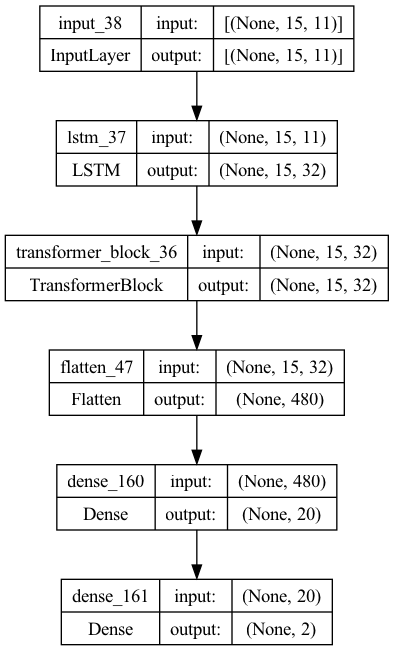

In [2414]:
tensorflow.keras.utils.plot_model(transformer_lstm_model, show_shapes=True)

In [2415]:
transformer_lstm_model_history = transformer_lstm_model.fit(train_data_single, epochs=30,validation_data=val_data_single)

Epoch 1/30
40/40 [==============================] - 2s 19ms/step - loss: 0.8189 - accuracy: 0.5071 - val_loss: 0.6739 - val_accuracy: 0.5861
Epoch 2/30
40/40 [==============================] - 1s 14ms/step - loss: 0.7259 - accuracy: 0.5190 - val_loss: 0.6473 - val_accuracy: 0.6588
Epoch 3/30
40/40 [==============================] - 1s 15ms/step - loss: 0.7189 - accuracy: 0.5019 - val_loss: 0.6469 - val_accuracy: 0.6600
Epoch 4/30
40/40 [==============================] - 1s 15ms/step - loss: 0.7165 - accuracy: 0.5063 - val_loss: 0.6513 - val_accuracy: 0.6592
Epoch 5/30
40/40 [==============================] - 1s 15ms/step - loss: 0.7163 - accuracy: 0.5105 - val_loss: 0.6965 - val_accuracy: 0.4874
Epoch 6/30
40/40 [==============================] - 1s 16ms/step - loss: 0.7062 - accuracy: 0.5085 - val_loss: 0.6689 - val_accuracy: 0.6457
Epoch 7/30
40/40 [==============================] - 1s 16ms/step - loss: 0.7062 - accuracy: 0.5057 - val_loss: 0.6853 - val_accuracy: 0.5632
Epoch 8/30
40

In [2416]:
for x, y in val_data_single.take(1):
  print(transformer_lstm_model.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 2)


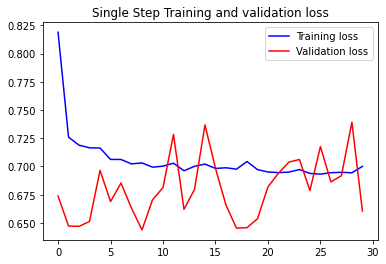

In [2417]:
plot_train_history(transformer_lstm_model_history,
                   'Single Step Training and validation loss')

### Results

In [2418]:
predict_score7 = transformer_lstm_model.predict(x_val_single)
predict_pro7 = layers.Softmax()(predict_score7)[:,1]
predict_label7 = np.argmax(predict_score7,axis=1)
predict_score7[:5],predict_pro7[:5],predict_label7[:5],y_val_single[:5] 

80/80 [==============================] - 0s 1ms/step


(array([[ 0.18801297, -0.03190888],
        [ 0.2319283 ,  0.00520971],
        [ 0.2702534 , -0.0621794 ],
        [ 0.16453466, -0.02013887],
        [-0.02616319, -0.22064136]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.44524008, 0.44356188, 0.41764885, 0.4539624 , 0.4515331 ],
       dtype=float32)>,
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]))

### roc

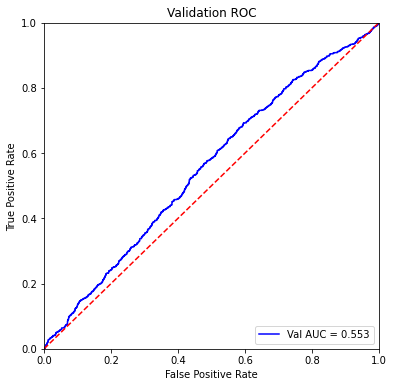

In [2419]:
fpr7, tpr7, threshold = metrics.roc_curve(y_val_single, predict_pro7)
roc_auc7 = metrics.auc(fpr7, tpr7)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr7, tpr7, 'b', label = 'Val AUC = %0.3f' % roc_auc7)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2420]:
p=df['label'].value_counts(1)[0]*100

threshold = np.percentile(predict_pro7, p)
print("threshold", threshold)

threshold 0.444622359668035


In [2421]:
predict_label7 = [1 if score>threshold else 0 for score in predict_pro7]

In [2422]:
new_pred_label = [get_pred_label(item,threshold, 0.02) for item in predict_pro7]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro7, 'new_pred_label':new_pred_label})
pd_result
pd_select = pd_result[pd_result.new_pred_label != -1]
len(pd_select)

797

In [2423]:
#predict_label7=new_pred_label

### auc

In [2424]:
roc_auc_score(y_val_single, predict_pro7)

0.5528892420675705

### classification report

In [2425]:
cr7=classification_report(y_val_single, predict_label7,digits=4)
print(cr7)

              precision    recall  f1-score   support

           0     0.6909    0.5732    0.6266      1673
           1     0.3759    0.5006    0.4294       859

    accuracy                         0.5486      2532
   macro avg     0.5334    0.5369    0.5280      2532
weighted avg     0.5840    0.5486    0.5597      2532



### confusion matrix

In [2426]:
cnf_matrix7 = confusion_matrix(y_val_single, predict_label7)
cnf_matrix7

array([[959, 714],
       [429, 430]])

<Axes: >

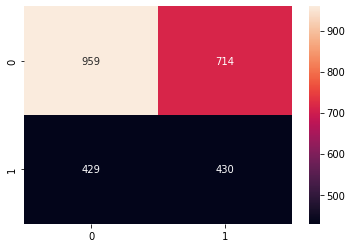

In [2427]:
sns.heatmap(cnf_matrix7, annot=True, fmt='g')

<Axes: >

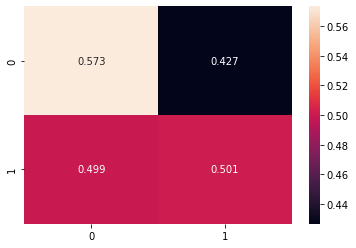

In [2428]:
cm_normalized = cnf_matrix7.astype('float') / cnf_matrix7.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2429]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label7
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]


2.0049392082119777

# transformer + lstm模型  parallel connected

### Add transformer encoder

In [2528]:
embed_dim = 11  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


In [2529]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [2530]:
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

### create transformer model

In [2531]:
input_tensor = tf.keras.Input(shape=train_input_shape)
lstm_tensor = tf.keras.layers.LSTM(8,return_sequences=True)(input_tensor)
tf_tensor = transformer_block(input_tensor)
mid_tensor = tf.keras.layers.Concatenate()([lstm_tensor, tf_tensor])
mid_tensor = tf.keras.layers.Flatten()(mid_tensor)
mid_tensor = tf.keras.layers.Dense(20)(mid_tensor)
final_tensor = tf.keras.layers.Dense(2)(mid_tensor)

# Instantiate an end-to-end model predicting both priority and department
transformer_lstm_model2 = tf.keras.Model(inputs=input_tensor,outputs=final_tensor,)

transformer_lstm_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# transformer_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae',metrics=['mae','mse',tf.keras.metrics.RootMeanSquaredError()])

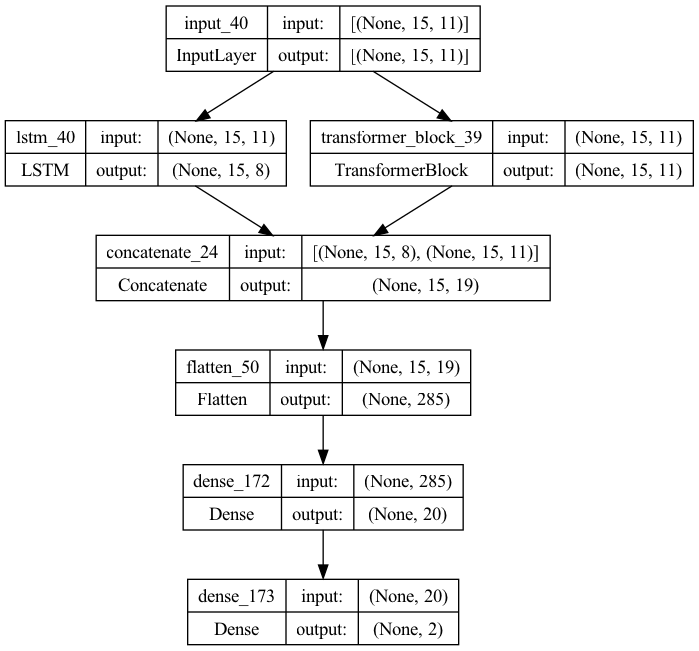

In [2532]:
tensorflow.keras.utils.plot_model(transformer_lstm_model2, show_shapes=True)

In [2533]:
transformer_lstm_model_history2 = transformer_lstm_model2.fit(train_data_single, epochs=30,validation_data=val_data_single)

Epoch 1/30
40/40 [==============================] - 3s 14ms/step - loss: 0.7480 - accuracy: 0.5010 - val_loss: 0.6957 - val_accuracy: 0.5158
Epoch 2/30
40/40 [==============================] - 0s 6ms/step - loss: 0.7121 - accuracy: 0.5130 - val_loss: 0.6481 - val_accuracy: 0.6603
Epoch 3/30
40/40 [==============================] - 0s 8ms/step - loss: 0.7072 - accuracy: 0.5042 - val_loss: 0.7225 - val_accuracy: 0.3756
Epoch 4/30
40/40 [==============================] - 0s 7ms/step - loss: 0.7032 - accuracy: 0.5085 - val_loss: 0.7338 - val_accuracy: 0.3555
Epoch 5/30
40/40 [==============================] - 0s 7ms/step - loss: 0.7030 - accuracy: 0.5101 - val_loss: 0.7321 - val_accuracy: 0.3606
Epoch 6/30
40/40 [==============================] - 0s 8ms/step - loss: 0.7024 - accuracy: 0.5047 - val_loss: 0.7059 - val_accuracy: 0.4317
Epoch 7/30
40/40 [==============================] - 0s 8ms/step - loss: 0.7018 - accuracy: 0.5096 - val_loss: 0.7376 - val_accuracy: 0.3511
Epoch 8/30
40/40 [=

In [2534]:
for x, y in val_data_single.take(1):
  print(transformer_lstm_model2.predict(x).shape)

8/8 [==============================] - 0s 2ms/step
(256, 2)


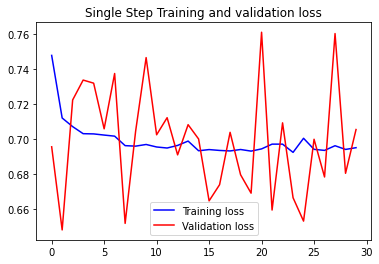

In [2535]:
plot_train_history(transformer_lstm_model_history2,
                   'Single Step Training and validation loss')

### Results

In [2536]:
predict_score8 = transformer_lstm_model2.predict(x_val_single)
predict_pro8 = layers.Softmax()(predict_score8)[:,1]
predict_label8 = np.argmax(predict_score8,axis=1)
predict_score8[:5],predict_pro8[:5],predict_label8[:5],y_val_single[:5]

80/80 [==============================] - 1s 2ms/step


(array([[-1.1782315 , -1.1046811 ],
        [-0.83910006, -0.8051391 ],
        [-0.7083693 , -0.78294265],
        [-0.87684894, -0.72763264],
        [-0.7791081 , -0.7113627 ]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.51837933, 0.50848943, 0.48136526, 0.537235  , 0.51692986],
       dtype=float32)>,
 array([1, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0]))

### roc

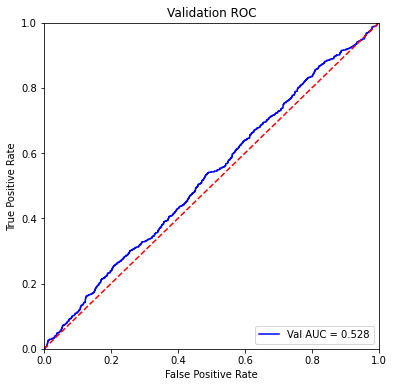

In [2537]:
fpr8, tpr8, threshold = metrics.roc_curve(y_val_single, predict_pro8)
roc_auc8 = metrics.auc(fpr8, tpr8)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr8, tpr8, 'b', label = 'Val AUC = %0.3f' % roc_auc8)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [2538]:
p=df['label'].value_counts(1)[0]*100
threshold = np.percentile(predict_pro8, 57)

print("threshold", threshold)

predict_label8 = [1 if score>threshold else 0 for score in predict_pro8]


threshold 0.5237381482124328


### auc

In [2539]:
roc_auc_score(y_val_single, predict_pro8)

0.5279398124148028

### classification report

In [2540]:
cr8=classification_report(y_val_single, predict_label8,digits=4)
print(cr8)

              precision    recall  f1-score   support

           0     0.6708    0.5786    0.6213      1673
           1     0.3526    0.4470    0.3943       859

    accuracy                         0.5340      2532
   macro avg     0.5117    0.5128    0.5078      2532
weighted avg     0.5629    0.5340    0.5443      2532



### confusion matrix

In [2541]:
cnf_matrix8 = confusion_matrix(y_val_single, predict_label8)
cnf_matrix8 

array([[968, 705],
       [475, 384]])

<Axes: >

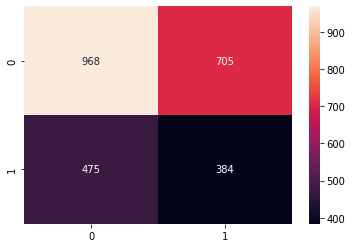

In [2542]:
sns.heatmap(cnf_matrix8, annot=True, fmt='g')

<Axes: >

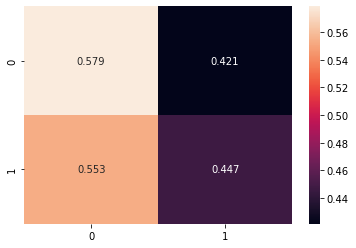

In [2543]:
cm_normalized = cnf_matrix8.astype('float') / cnf_matrix8.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2553]:
new_pred_label = [get_pred_label(item,threshold,0.0) for item in predict_pro8]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro8, 'new_pred_label':new_pred_label})
pd_result
pd_select = pd_result[pd_result.new_pred_label != -1]
pred_label8=new_pred_label
len(pd_select)

2532

In [2554]:
predict_label8=new_pred_label

In [2555]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label']=predict_label8
#df1['new_pred_label']=new_pred_label

df1['pred_return'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label'] == 0 else row['return'], axis=1)
df1['Cumulative Return'] = (1 + df1['pred_return']).cumprod()-1

df1['Cumulative Return'].iloc[-1]

0.26409353037768724

# time2vec+tf+lstm

### transformer encoder

In [2450]:
embed_dim = 13  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [2451]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [2452]:
input_shape_eg = (12,15,13)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
eg_tensor = tf.random.normal(input_shape_eg)
transformer_block(eg_tensor).shape

TensorShape([12, 15, 13])

### time2Vector layer

In [2453]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [2454]:
input_shape_eg = (10,15,12)
eg_tensor = tf.random.normal(input_shape_eg)
time_embedding = Time2Vector(seq_len)
time_embedding(eg_tensor).shape

TensorShape([10, 15, 2])

In [2455]:
dropout_rate = 0.1

input_tensor = tf.keras.Input(shape=train_input_shape, name='model_input')
time_embedding = Time2Vector(seq_len)
time_tensor = time_embedding(input_tensor)
mid_tensor = tf.keras.layers.concatenate([time_tensor, input_tensor])

print(mid_tensor.shape)

lstm_tensor = tf.keras.layers.LSTM(8, return_sequences=True)(mid_tensor)
tf_tensor = transformer_block(mid_tensor)
mid_tensor = tf.keras.layers.Concatenate()([lstm_tensor, tf_tensor])
mid_tensor = tf.keras.layers.Dropout(rate=dropout_rate)(mid_tensor)
mid_tensor = tf.keras.layers.Flatten()(mid_tensor)
mid_tensor = tf.keras.layers.Dense(20)(mid_tensor)
final_tensor = tf.keras.layers.Dense(2)(mid_tensor)

big_model = tf.keras.Model(inputs=input_tensor, outputs=final_tensor)

big_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


(None, 15, 13)


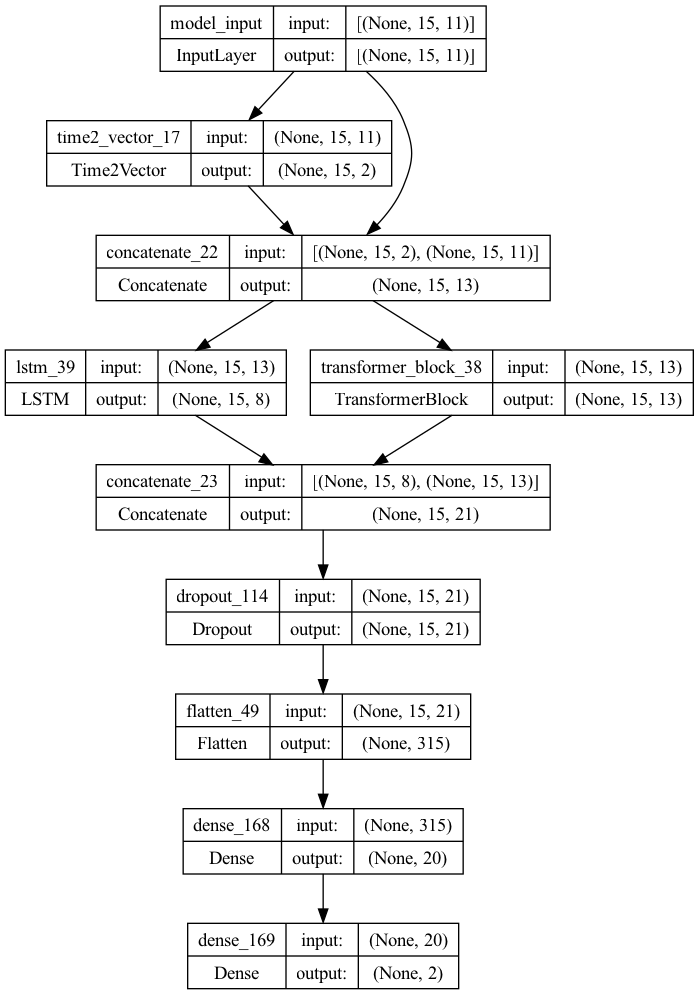

In [2456]:
tf.keras.utils.plot_model(big_model, show_shapes=True)

In [2457]:
big_model_history = big_model.fit(train_data_single, epochs=40,validation_data=val_data_single)
#batch_size=128,

Epoch 1/40
40/40 [==============================] - 2s 13ms/step - loss: 0.7828 - accuracy: 0.5026 - val_loss: 0.7289 - val_accuracy: 0.4210
Epoch 2/40
40/40 [==============================] - 0s 6ms/step - loss: 0.7320 - accuracy: 0.5045 - val_loss: 0.6677 - val_accuracy: 0.6248
Epoch 3/40
40/40 [==============================] - 0s 7ms/step - loss: 0.7170 - accuracy: 0.5007 - val_loss: 0.6897 - val_accuracy: 0.5509
Epoch 4/40
40/40 [==============================] - 0s 8ms/step - loss: 0.7126 - accuracy: 0.5107 - val_loss: 0.6566 - val_accuracy: 0.6623
Epoch 5/40
40/40 [==============================] - 0s 8ms/step - loss: 0.7043 - accuracy: 0.5032 - val_loss: 0.6655 - val_accuracy: 0.6532
Epoch 6/40
40/40 [==============================] - 0s 8ms/step - loss: 0.7018 - accuracy: 0.5010 - val_loss: 0.6628 - val_accuracy: 0.6576
Epoch 7/40
40/40 [==============================] - 0s 8ms/step - loss: 0.6999 - accuracy: 0.5101 - val_loss: 0.6403 - val_accuracy: 0.6607
Epoch 8/40
40/40 [=

In [2458]:
for x, y in val_data_single.take(1):
  print(big_model.predict(x).shape)

8/8 [==============================] - 0s 1ms/step
(256, 2)


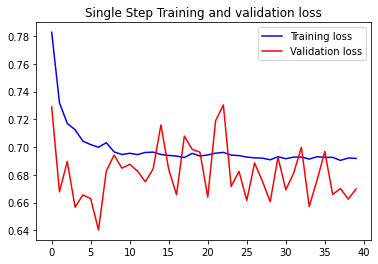

In [2459]:
plot_train_history(big_model_history,
                   'Single Step Training and validation loss')

### Results

In [2460]:
predict_score9= big_model.predict(x_val_single)
predict_pro9 = layers.Softmax()(predict_score9)[:,1]
predict_label9 = np.argmax(predict_score9,axis=1)
predict_score9[:5],predict_pro9[:5],predict_label9[:5],y_val_single[:5]

80/80 [==============================] - 0s 823us/step


(array([[-0.0638275 , -0.33857417],
        [-0.10241268, -0.3307953 ],
        [ 0.5268836 ,  0.12506695],
        [ 0.22697116,  0.19333294],
        [ 0.14339241, -0.00502814]], dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.43174216, 0.44315124, 0.400876  , 0.49159124, 0.46296284],
       dtype=float32)>,
 array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0]))

### roc

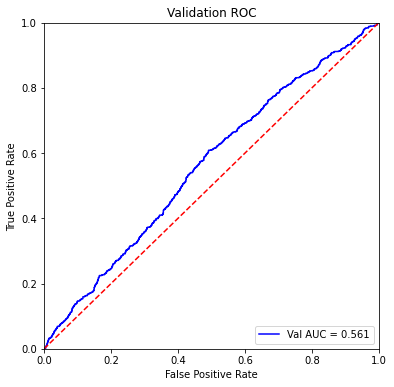

In [2461]:
fpr9, tpr9, threshold = metrics.roc_curve(y_val_single, predict_pro9)
roc_auc9 = metrics.auc(fpr9, tpr9)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr9, tpr9, 'b', label = 'Val AUC = %0.3f' % roc_auc9)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [2648]:
p=df['label'].value_counts(1)[0]*100
threshold = np.percentile(predict_pro9, p)

print("threshold", threshold)

threshold 0.46904416307678287


In [2649]:
predict_label9 = [1 if score>threshold else 0 for score in predict_pro9]

### auc

In [2650]:
roc_auc_score(y_val_single, predict_pro9)

0.560604046880295

### classification report

In [2651]:
cr9=classification_report(y_val_single, predict_label9,digits=4)
print(cr9)

              precision    recall  f1-score   support

           0     0.6974    0.5786    0.6325      1673
           1     0.3837    0.5111    0.4383       859

    accuracy                         0.5557      2532
   macro avg     0.5406    0.5448    0.5354      2532
weighted avg     0.5910    0.5557    0.5666      2532



### confusion matrix

In [2652]:
cnf_matrix9 = confusion_matrix(y_val_single, predict_label9)
cnf_matrix9

array([[968, 705],
       [420, 439]])

<Axes: >

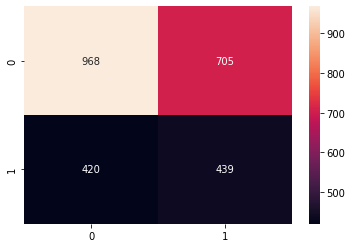

In [2653]:
sns.heatmap(cnf_matrix9, annot=True, fmt='g')

<Axes: >

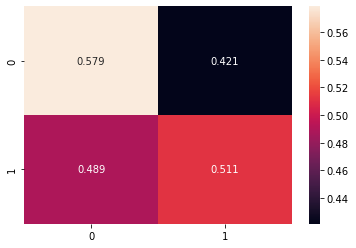

In [2654]:
cm_normalized = cnf_matrix9.astype('float') / cnf_matrix9.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

In [2655]:
def get_pred_label9(item, gap):
  low_line = threshold-gap
  high_line = threshold+gap
  if item<low_line:
    return 0
  elif item >= low_line and item <= high_line:
    return -1
  elif item > high_line:
    return 1


In [2656]:
new_pred_label = [get_pred_label9(item, 0) for item in predict_pro9]
pd_result = pd.DataFrame({'label':y_val_single, 'pred_score':predict_pro9, 'new_pred_label':new_pred_label})
pd_result
pd_select = pd_result[pd_result.new_pred_label != -1]
len(pd_select) 

2532

In [2657]:
predict_label9=new_pred_label

In [2658]:
df1=pd.DataFrame()
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1['pred_label1']=predict_label9
#df1['new_pred_label']=new_pred_label

df1['pred_return1'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label1'] == 0 else row['return'] if row['pred_label1'] == 1 else 0, axis=1)

df1['Cum_return1'] = (1 + df1['pred_return1']).cumprod()-1
df1.drop('pred_return1', axis=1, inplace=True)

df1['Cum_return1'].iloc[-1]

1.5552312625375548

# ALL

In [2898]:
model_list=['Random forest','Decision tree','transformer','LSTM','CNN','LSTM+CNN','Transformer+LSTM1','Transformer+LSTM2','Time2Vec+Transformer+LSTM','RL']

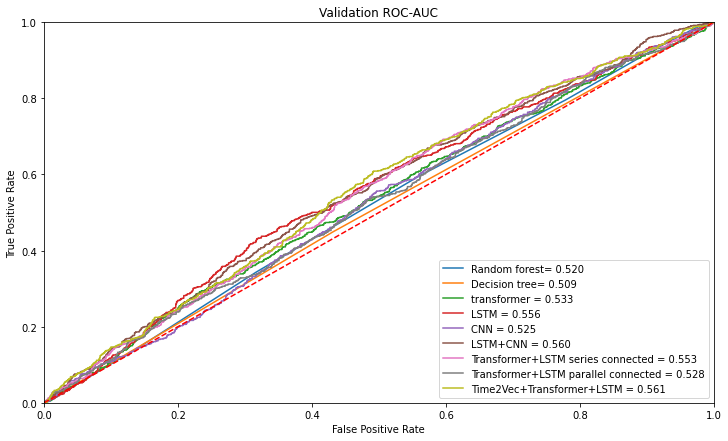

In [2807]:
fig, axs = plt.subplots(figsize=(12,7))
axs.set_title('Validation ROC-AUC')
axs.plot(fpr1, tpr1, label='Random forest= %0.3f' % roc_auc1)
axs.plot(fpr2, tpr2, label='Decision tree= %0.3f' % roc_auc2)
axs.plot(fpr3, tpr3, label='transformer = %0.3f' % roc_auc3)
axs.plot(fpr4, tpr4, label='LSTM = %0.3f' % roc_auc4)
axs.plot(fpr5, tpr5, label='CNN = %0.3f' % roc_auc5)
axs.plot(fpr6, tpr6, label='LSTM+CNN = %0.3f' % roc_auc6)
axs.plot(fpr7, tpr7, label='Transformer+LSTM series connected = %0.3f' % roc_auc7)
axs.plot(fpr8, tpr8, label='Transformer+LSTM parallel connected = %0.3f' % roc_auc8)
axs.plot(fpr9, tpr9, label='Time2Vec+Transformer+LSTM = %0.3f' % roc_auc9)

axs.legend(loc='lower right')
axs.plot([0, 1], [0, 1], 'r--')
axs.set_xlim([0, 1])
axs.set_ylim([0, 1])
axs.set_ylabel('True Positive Rate')
axs.set_xlabel('False Positive Rate')

#fig.savefig('roc.eps', format='eps')
plt.show()

In [ ]:
df1=pd.DataFrame()
df1['DATETIME']=df['DATETIME'][-len(y_val_single):]
df1['price']=df['PRICE'][-len(y_val_single):]
df1=df1.reset_index(drop=True)
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()
df1['label']=y_val_single
df1[['Date', 'Time']] = df1['DATETIME'].str.split(' ', 1, expand=True)

predictors = [predict_label1, predict_label2, predict_label3, predict_label4, predict_label5, predict_label6, predict_label7, predict_label8, predict_label9]


for i in range(1,10):
    df1[f'pred_label{i}']=predictors[i-1]
    df1[f'pred_return{i}'] = df1.apply(lambda row: row['return'] * (-1) if row[f'pred_label{i}'] == 0 else row['return'] if row[f'pred_label{i}'] == 1 else 0, axis=1)
    df1[f'Cum_return{i}'] = (1 + df1[f'pred_return{i}']).cumprod()-1 

In [2664]:
#df1 = df1.loc[df1['DATETIME'].str.contains('16:00:00')]
df1['return']=df1['price'].pct_change()
df1['diff']=df1['price'].diff()


for i in range(1,10):
    df1[f'pred_return{i}'] = df1.apply(lambda row: row['return'] * (-1) if row[f'pred_label{i}'] == 0 else row['return'] if row[f'pred_label{i}'] == 1 else 0, axis=1)
    df1[f'Cum_return{i}'] = (1 + df1[f'pred_return{i}']).cumprod()-1 
    df1.drop(f'pred_label{i}', axis=1, inplace=True) 
rl_pred = pd.read_csv('/Users/hecate/Downloads/rl_pred_label.csv')
df1['pred_label10']=rl_pred['pred_label']
df1['pred_return10'] = df1.apply(lambda row: row['return'] * (-1) if row['pred_label10'] == 0 else row['return'] if row['pred_label10'] == 1 else 0, axis=1)
df1['Cum_return10'] = (1 + df1['pred_return10']).cumprod()-1

df2 = df1.groupby('Date').mean()
df2

/var/folders/vj/hl44tyxn2t1ccmc23733qvlh0000gn/T/ipykernel_14393/2964161932.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df1.groupby('Date').mean()


,price,return,diff,label,pred_return1,Cum_return1,pred_return2,Cum_return2,pred_return3,Cum_return3,...,Cum_return6,pred_return7,Cum_return7,pred_return8,Cum_return8,pred_return9,Cum_return9,pred_label10,pred_return10,Cum_return10
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-16,211.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
2021-12-17,214.678571,0.001678,0.357143,0.357143,-0.002544,-0.022651,0.000725,0.001583,0.001410,0.010793,...,0.012634,0.000807,0.006920,0.001410,0.010793,0.000807,0.006920,0.214286,-0.001477,-0.011757
2021-12-20,212.885714,-0.000822,-0.185714,0.285714,0.002919,0.001521,0.001373,0.035463,0.003002,0.062894,...,0.040472,0.002180,0.042866,0.002999,0.062090,0.002253,0.042993,0.571429,-0.003191,-0.058858
2021-12-21,220.621429,0.003212,0.700000,0.500000,-0.000778,-0.001306,-0.002419,0.007059,-0.000429,0.050425,...,0.013379,0.001826,0.056641,-0.002568,0.033167,-0.001078,0.023867,0.142857,-0.003212,-0.091293
2021-12-22,224.628571,0.000331,0.071429,0.428571,0.000755,0.001613,-0.002371,-0.035559,-0.001546,0.032368,...,0.001559,-0.000189,0.063031,-0.001609,0.001280,0.000068,0.024850,0.285714,-0.001077,-0.117485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,200.660000,-0.000587,-0.120000,0.400000,0.000587,0.394280,0.000587,0.374995,0.000408,0.452351,...,1.810294,-0.000587,2.032442,0.000010,0.330641,-0.000587,1.622477,0.800000,0.002788,0.004841
2022-12-27,201.400000,0.001342,0.266667,0.666667,-0.003645,0.380745,0.001342,0.382174,0.001342,0.458578,...,1.820658,0.001342,2.043625,-0.003645,0.316500,0.001342,1.632148,0.333333,-0.000015,0.010978
2022-12-28,200.560000,-0.001185,-0.240000,0.600000,0.001585,0.385640,0.001389,0.382977,-0.001185,0.452495,...,1.808893,0.002188,2.051494,-0.003378,0.301910,-0.001185,1.621170,0.600000,0.003778,0.025394


In [2665]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    avg_return = np.mean(returns)
    std_dev = np.std(returns)
    excess_return = avg_return - risk_free_rate
    sharpe_ratio = excess_return / std_dev
    annualized_Sharpe_ratio=(252**0.5) * sharpe_ratio
    return annualized_Sharpe_ratio


calculate_sharpe_ratio(df1['pred_return3'])


def calculate_calmar_ratio(returns, max_drawdown):
    avg_return = np.mean(returns)
    calmar_ratio = avg_return / abs(max_drawdown)
    
    return calmar_ratio



In [2666]:
import empyrical as ep
return_columns = [f'pred_return{i}' for i in range(1, 11)]

sharpe_values = []
calmar_values = []
sortino_values = []
max_dd_values = []
downside_risk_values = []
ann_return_values = []
ann_volatility_values = []


for column in return_columns:
    returns = df1[column]
    sharpe = ep.sharpe_ratio(returns)
    calmar = ep.calmar_ratio(returns)
    sortino = ep.sortino_ratio(returns)
    max_dd = ep.max_drawdown(returns)
    downside_risk_value = ep.downside_risk(returns)
    ann_return = ep.annual_return(returns)
    ann_volatility = ep.annual_volatility(returns)
    
    sharpe_values.append(sharpe)
    calmar_values.append(calmar)
    sortino_values.append(sortino)
    max_dd_values.append(max_dd)
    downside_risk_values.append(downside_risk_value)
    ann_return_values.append(ann_return)
    ann_volatility_values.append(ann_volatility)

metrics_df = pd.DataFrame({
    'Model': model_list,
    'Sharpe Ratio': sharpe_values,
    'Calmar Ratio': calmar_values,
    'Sortino Ratio': sortino_values,
    'Max Drawdown': max_dd_values,
    'Downside Risk': downside_risk_values,
    'Annual Return': ann_return_values,
    'Annual Volatility': ann_volatility_values})

print(metrics_df)


                       Model  Sharpe Ratio  Calmar Ratio  Sortino Ratio  \
0              Random forest      0.348365      0.113420       0.479346   
1              Decision tree      0.310119      0.132964       0.473293   
2                transformer      0.348803      0.150912       0.508354   
3                       LSTM      0.789092      0.464358       1.230609   
4                        CNN      0.347013      0.104258       0.528663   
5                   LSTM+CNN      0.902545      0.658774       1.379950   
6          Transformer+LSTM1      0.997263      0.973779       1.608767   
7          Transformer+LSTM2      0.257858      0.060788       0.388581   
8  Time2Vec+Transformer+LSTM      0.858634      0.479397       1.320843   
9                         RL      0.062085      0.001403       0.090478   

   Max Drawdown  Downside Risk  Annual Return  Annual Volatility  
0     -0.303358       0.084923       0.034407           0.116853  
1     -0.224706       0.076571       0.0

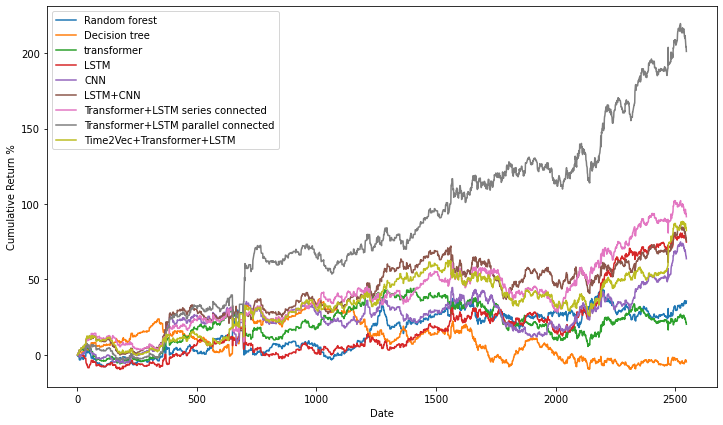

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(df1['Cum_return1']*100, label='Random forest')
ax.plot(df1['Cum_return2']*100, label='Decision tree')
ax.plot(df1['Cum_return3']*100, label='transformer')
ax.plot(df1['Cum_return4']*100, label='LSTM')
#ax.plot(df1['Cum_return10']*100, label='DDPG')
ax.plot(df1['Cum_return5']*100, label='CNN')
ax.plot(df1['Cum_return6']*100, label='LSTM+CNN')
ax.plot(df1['Cum_return7']*100, label='Transformer+LSTM series connected')
ax.plot(df1['Cum_return8']*100, label='Transformer+LSTM parallel connected')
ax.plot(df1['Cum_return9']*100, label='Time2Vec+Transformer+LSTM')
#ax.legend(fontsize=20)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return %')
#ax.set_title('Cumulative Return Curves')
ax.legend()
#fig.savefig('CumulativeReturn.eps', format='eps')
plt.show() 

In [2668]:
print(model_list[0])
print(cr1)
print(model_list[1])
print(cr2)
print(model_list[2])
print(cr3)

Random forest
              precision    recall  f1-score   support

           0     0.6742    0.7089    0.6911      1673
           1     0.3700    0.3329    0.3505       859

    accuracy                         0.5814      2532
   macro avg     0.5221    0.5209    0.5208      2532
weighted avg     0.5710    0.5814    0.5756      2532

Decision tree
              precision    recall  f1-score   support

           0     0.6678    0.5684    0.6141      1673
           1     0.3484    0.4494    0.3925       859

    accuracy                         0.5280      2532
   macro avg     0.5081    0.5089    0.5033      2532
weighted avg     0.5595    0.5280    0.5389      2532

transformer
              precision    recall  f1-score   support

           0     0.6819    0.5882    0.6316      1673
           1     0.3673    0.4657    0.4107       859

    accuracy                         0.5466      2532
   macro avg     0.5246    0.5269    0.5211      2532
weighted avg     0.5752    0.5466 

In [2669]:
print(model_list[3])
print(cr4)
print(model_list[4])
print(cr5)
print(model_list[5])
print(cr6)

LSTM
              precision    recall  f1-score   support

           0     0.6945    0.5762    0.6299      1673
           1     0.3802    0.5064    0.4343       859

    accuracy                         0.5525      2532
   macro avg     0.5374    0.5413    0.5321      2532
weighted avg     0.5879    0.5525    0.5635      2532

CNN
              precision    recall  f1-score   support

           0     0.6722    0.5798    0.6226      1673
           1     0.3545    0.4494    0.3963       859

    accuracy                         0.5355      2532
   macro avg     0.5133    0.5146    0.5094      2532
weighted avg     0.5644    0.5355    0.5458      2532

LSTM+CNN
              precision    recall  f1-score   support

           0     0.6967    0.5780    0.6318      1673
           1     0.3829    0.5099    0.4373       859

    accuracy                         0.5549      2532
   macro avg     0.5398    0.5439    0.5346      2532
weighted avg     0.5902    0.5549    0.5658      2532



In [2673]:
print(model_list[6])
print(cr7)
print(model_list[7])
print(cr8)
print(model_list[8])
print(cr9)

Transformer+LSTM1
              precision    recall  f1-score   support

           0     0.6909    0.5732    0.6266      1673
           1     0.3759    0.5006    0.4294       859

    accuracy                         0.5486      2532
   macro avg     0.5334    0.5369    0.5280      2532
weighted avg     0.5840    0.5486    0.5597      2532

Transformer+LSTM2
              precision    recall  f1-score   support

           0     0.6708    0.5786    0.6213      1673
           1     0.3526    0.4470    0.3943       859

    accuracy                         0.5340      2532
   macro avg     0.5117    0.5128    0.5078      2532
weighted avg     0.5629    0.5340    0.5443      2532

Time2Vec+Transformer+LSTM
              precision    recall  f1-score   support

           0     0.6974    0.5786    0.6325      1673
           1     0.3837    0.5111    0.4383       859

    accuracy                         0.5557      2532
   macro avg     0.5406    0.5448    0.5354      2532
weighted avg

In [2805]:
cnf_matrix,cnf_matrix2,cnf_matrix3,cnf_matrix4,cnf_matrix5,cnf_matrix6,cnf_matrix7,cnf_matrix8,cnf_matrix9,

(array([[1152,  534],
        [ 566,  296]]),
 array([[951, 722],
        [473, 386]]),
 array([[984, 689],
        [459, 400]]),
 array([[964, 709],
        [424, 435]]),
 array([[970, 703],
        [473, 386]]),
 array([[967, 706],
        [421, 438]]),
 array([[959, 714],
        [429, 430]]),
 array([[968, 705],
        [475, 384]]),
 array([[968, 705],
        [420, 439]]))